<a href="https://colab.research.google.com/github/spike-h/AP-PA-Classifier/blob/main/Dataset_Creator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

##Pips (restart runtime after running)

In [ ]:
'''
 importing from https://github.com/Engineero/tf_sprinkles
'''
!pip install tf_sprinkles &> /dev/null
!pip install pydicom &> /dev/null
!pip install pylibjpeg pylibjpeg-libjpeg  &> /dev/null
!pip install python-gdcm &> /dev/null
!pip install -q tensorflow-io &> /dev/null
!pip install numpy --upgrade

     |████████████████████████████████| 15.7 MB 309 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


##imports

In [ ]:
import os

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import random
from tf_sprinkles import Sprinkles
import pydicom
from tqdm import tqdm
import pylibjpeg
import gdcm
import tensorflow_io as tfio
import time
# import tracemalloc

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)

TF version: 2.6.0
Hub version: 0.12.0


In [ ]:
colabDir = '/content/drive/MyDrive/AP PA Stuff/Datasets/Original/'
tensorflowDir = '/content/drive/MyDrive/AP PA Stuff/Datasets/Tensorflow/'

#Creating tf.data.Dataset Datasets

##Helper/Starter functions

In [ ]:
class_distributions = {}

In [ ]:
#Sprinkles augmentation setup

#Set sprinkles to make 50-100 square holes in the image with side length of 10 pixels 30% ofthe time
class RandomSprinkles(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()

  def call(self, image):
    if random.random() < .3:
      sprinkles = Sprinkles(num_holes=random.randint(50,100), side_length=10)
      return sprinkles(image)
    return image

In [69]:
#Helper functions to create and augment the tf.data.Datasets
IMG_SIZE = 256 #IF CHANGE HERE THEN ALSO CHANGE IN TRAIN MODEL.py
BATCH_SIZE = 16 #IF CHANGE HERE THEN ALSO CHANGE IN TRAIN MODEL.py
rngJesus = 8679309 #set seed for consistency when running but doesnt affect sprinkles soooooo maybe pointless

def read_image(filename, label, bmp=None):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_image(image_string, channels=3, expand_animations=False)
  image = tf.cast(image_decoded, tf.float32) / 255.0
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  return image, label

def read_dicom_image(dcmFile, label):
  # image_decoded = tf.convert_to_tensor(dcmFile)
  # image_decoded = tf.expand_dims(image_decoded, axis=-1)
  image = tf.image.grayscale_to_rgb(dcmFile)
  print('a')
  image = tf.cast(image, tf.float32) / 255.0
  print('b')
  # image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  return image, label

preprocessing_model = tf.keras.Sequential([
  RandomSprinkles(),
  tf.keras.layers.RandomFlip("horizontal", seed=rngJesus),
  tf.keras.layers.RandomContrast(factor=0.1, seed=rngJesus),
  tf.keras.layers.RandomTranslation(0, 0.1, fill_mode='constant', seed=rngJesus),
  tf.keras.layers.RandomTranslation(0.1, 0, fill_mode='constant', seed=rngJesus),
  tf.keras.layers.RandomRotation(.069, fill_mode='constant', seed=rngJesus)
])
# preprocessing_model.add(
#   tf.keras.layers.RandomRotation(.111, fill_mode='constant', seed=rngJesus)),
# preprocessing_model.add(
#   tf.keras.layers.RandomTranslation(0, 0.1, fill_mode='constant', seed=rngJesus))
# preprocessing_model.add(
#   tf.keras.layers.RandomTranslation(0.1, 0, fill_mode='constant', seed=rngJesus))
# # preprocessing_model.add(
# #   tf.keras.layers.RandomZoom(0.05, 0.05, fill_mode='constant', seed=rngJesus))
# preprocessing_model.add(
#   tf.keras.layers.RandomFlip("horizontal", seed=rngJesus))
# preprocessing_model.add(RandomSprinkles())

#Function to show image
def show_image(dataset):
  dataset = dataset.take(1)
  image, label = next(iter(dataset))
  image = image[0,:,:,:]
  plt.imshow(image)
  plt.axis('off')
  plt.show()

#Training/Validation/Test Split
def training_split(dataset, training_prop=0.8, validation_prop=0.1, testing_prop=0.1, train=False):
  print('c')
  dataset_size = dataset.cardinality().numpy()
  print('d')
  train_size = int(training_prop * dataset_size)
  print('e')
  val_size = int(validation_prop * dataset_size)
  print('f')
  test_size = int(testing_prop * dataset_size)
  print('g')
  
  if not train:
    train_ds = dataset.take(train_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    #.prefetch(tf.data.AUTOTUNE)   
    print('h') 
    val_ds = dataset.skip(train_size).take(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print('i')
    test_ds = dataset.skip(train_size).skip(val_size).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    print('j')
  
  else:
    train_ds = dataset.take(train_size)
    #.prefetch(tf.data.AUTOTUNE)   
    print('h') 
    val_ds = dataset.skip(train_size).take(val_size)
    print('i')
    test_ds = dataset.skip(train_size).skip(val_size)
    print('j')
  
  return train_ds, val_ds, test_ds

def normalize(image, label):
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

While many of the cells will look mostly the same, the difference lies in the file paths and metadata csv fields (and some variable names)

##Training


In [ ]:
def random_shard(shard_size, dataset_size):
  num_shards = -(-dataset_size // shard_size)  # Ceil division.
  offsets = np.linspace(
      0, dataset_size, num=num_shards, endpoint=False, dtype=np.int64)

  def _random_shard(dataset):
    sharded_dataset = tf.data.Dataset.from_tensor_slices(offsets)
    sharded_dataset = sharded_dataset.shuffle(num_shards)
    sharded_dataset = sharded_dataset.map(
        lambda offset: dataset.skip(offset).take(shard_size))
    print(sharded_dataset)
    return sharded_dataset

  return _random_shard


In [ ]:
import gc
count = 0
def read_training_dataset(file_name, label):
  image = tf.io.read_file(file_name)
  if label == 999.0:
    label = tfio.image.decode_dicom_data(image, tags=[tfio.image.dicom_tags.SeriesDescription])[0]
    image = tfio.image.decode_dicom_image(image)[0,:,:,:]
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.image.grayscale_to_rgb(image)
    if tf.strings.regex_full_match(label, "(.*AP.*)"):
      label = 0.0
    elif tf.strings.regex_full_match(label, "(.*PA.*)"):
      label = 1.0
    else:
      label = 999.0
      print(label)
  else:
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  time.sleep(.002)
  gc.collect()
  return image, label


In [ ]:
def better_sharding(dataset, num_shards):
  return tf.data.Dataset.from_tensor_slices([dataset.shard(num_shards, i) for i in range(0,num_shards)])

In [ ]:
#TEST ON 13-24 FILE GROUPS AND KAGGLE TEST

In [ ]:
Kaggle_AP = 0
Kaggle_PA = 0
IEEE_PA = 0
IEEE_AP = 0
epoch_number = 9
num_shards = 4

def train_gen(half=None):
  global file_count
  global Kaggle_AP
  global Kaggle_PA
  global IEEE_AP
  global IEEE_PA

  dataDir = 'stage_2_train_images/'

  #Getting dcm file paths from premade folders
  #I manually Separated dcm into seperate folders bc google couldnt read 26k files in one line
  file_paths = []
  labels = []
  dcm_dir_names = [str(i) for i in range(1,25)]
  for name in dcm_dir_names:
    dcm_dir = colabDir + dataDir + name + '/'
    files = os.listdir(dcm_dir)
    for file in files:
      file_paths.append(dcm_dir + file)
      labels.append(999.0)

  # dataDir = 'stage_2_test_images/'
  # dcm_files = os.listdir(colabDir + dataDir)
  # for dcm in dcm_files:
  #   file_paths.append(colabDir + dataDir + dcm)
  #   labels.append('placeholder')

  # ind=0
  # if half:
  #   half = 10000
  # while ind<len(file_paths[:half]):
  #   dcm = pydicom.dcmread(file_paths[ind])
  #   image = dcm.pixel_array
  #   image = tf.image.resize(tf.expand_dims(image, axis=-1), [IMG_SIZE, IMG_SIZE])
  #   image = tf.image.grayscale_to_rgb(image)
  #   label = dcm.SeriesDescription
  #   if 'AP' in label:
  #     Kaggle_AP += 1
  #     label = 0.0
  #   elif 'PA' in label:
  #     Kaggle_PA += 1
  #     label = 1.0
  #   yield image, label
  #   ind+=1

  dataDir = 'covid-chestxray-dataset-master/covid-chestxray-dataset-master/'

  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' #train metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['view'].str.contains('AP|PA', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  IEEE_file_paths = metadata['filename'].values

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(IEEE_file_paths):
    IEEE_file_paths[ind] = colabDir + dataDir + 'images/' + path
  file_paths.extend(IEEE_file_paths)

  #Get AP/PA label
  IEEE_labels = metadata['view'].values
  labels.extend(IEEE_labels)

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  # for ind, label in enumerate(labels):

  #oop cheXpert time (run that cell first)
  file_paths.extend(cheXpert_train_files_and_labels[0])
  labels.extend(cheXpert_train_files_and_labels[1])

  for ind, label in enumerate(labels):
    if label == 999.0 or label == 0.0 or label == 1.0:
      continue
    elif 'AP' in label:
      labels[ind] = 0.0
    elif 'PA' in label:
      labels[ind] = 1.0

  zipped = list(zip(file_paths, labels))
  random.shuffle(zipped)

  ind=0
  while ind<len(zipped):
    # image = tf.io.read_file(file_paths[ind])
    # image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # label = labels[ind]
    yield zipped[ind][0], zipped[ind][1]
    ind+=1

In [ ]:
def create_train():
  dataset = tf.data.Dataset.from_generator(train_gen, output_signature=(tf.TensorSpec(shape=(), dtype=tf.string), tf.TensorSpec(shape=(), dtype=tf.float32)))
  dataset = dataset.apply(tf.data.experimental.assert_cardinality(47466)) #26684(kaggle) + 782(IEEE) + 20000(CheXpert)
  dataset_length = dataset.cardinality().numpy()
  buffer_size = int(.25 * dataset_length)
  # shard_size = -(-dataset_size // num_shards)
  
  # shuffled_shards = []
  # for i in shards:
  #     subshard = shard(i)
  #     subshard = subshard.interleave(lambda x: x, cycle_length=4, block_length=1)
  #     shuffled_shards.append(subshard.shuffle(buffer_size=buffer_size))
  # shuffled_shards = tf.data.Dataset.from_tensor_slices(shuffled_shards)
  # dataset = shuffled_shards.interleave(lambda x: x, cycle_length=4, block_length=1)
  # dataset = dataset.shuffle(num_shards)
  # print(dataset)
  dataset = dataset.shuffle(buffer_size=buffer_size)
  dataset = dataset.map(read_training_dataset, num_parallel_calls=tf.data.AUTOTUNE)

  print(dataset)
  dataset = dataset.map(normalize)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=.8, validation_prop=.2, testing_prop=0, train=True)
  train_ds = train_ds.map(lambda images, labels: (preprocessing_model(images), labels))
  train_ds = train_ds.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
  valid_ds = valid_ds.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
  # test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
  return dataset_length, train_ds, valid_ds, test_ds
dataset_length, train_ds, valid_ds, test_ds = create_train()

999.0
<ParallelMapDataset shapes: ((256, 256, 3), ()), types: (tf.float32, tf.float32)>
c
d
e
f
g
h
i
j


In [ ]:
'''
def Construct_IEEE(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating ieee8023 Dataset (Covid-19 Image Data Collection)
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='Ieee8023 Dataset'
  dataDir = 'covid-chestxray-dataset-master/covid-chestxray-dataset-master/'

  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' #train metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['view'].str.contains('AP|PA', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  file_paths = metadata['filename'].values

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir + dataDir + 'images/' + path

  #Get AP/PA label
  labels = metadata['view'].values

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = 0
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [train_ds, valid_ds, test_ds]

IEEE_ds = Construct_IEEE(.8,.2,0,augment=True)
'''

"\ndef Construct_IEEE(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): \n  # Creating ieee8023 Dataset (Covid-19 Image Data Collection)\n  # returns list: [train_ds(augmented), valid_ds, test_ds]\n  # augment used to check if should apply random flip, rotation, etc.\n  # NumImages used to determine how many images to include in database (if left blank then it takes all images)\n  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split\n\n  name ='Ieee8023 Dataset'\n  dataDir = 'covid-chestxray-dataset-master/covid-chestxray-dataset-master/'\n\n  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' #train metadata path\n  metadata = pd.read_csv(METADATA_CSV_PATH)\n\n  #Only taking the rows that contain a value for view position\n  metadata = metadata[metadata['view'].str.contains('AP|PA', case=False, regex=True, na=False)]\n\n  #Getting image file paths from csv\n  file_paths = metadata['filename'].values\n\n  #Colab file path example:

###KAGGLE Train

In [ ]:
'''
def Construct_KaggleTrain(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating Kaggle Train Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='Kaggle Train Dataset'
  # dataDir = 'stage_2_train_images/'

  #Getting dcm file paths from premade folders
  #I manually Separated dcm into seperate folders bc google couldnt read 26k files in one line
  # file_paths = []
  # dcm_dir_names = [str(i) for i in range(1,2)]
  # for name in dcm_dir_names:
  #   dcm_dir = colabDir + dataDir + name + '/'
  #   files = os.listdir(dcm_dir)
  #   for file in files:
  #     file_paths.append(dcm_dir + file)

  
  #Split file_paths list into 500 file chunks to avoid ram overload when converting to tensor array
  # file_groups = [file_paths[i:i + 500] for i in range(0, len(file_paths), 500)]
  # ds_list = []

  # for group in tqdm(file_groups):
  # dcm_pixel_arrays = []
  # labels = []
  # for path in file_paths:
  #   dcm = pydicom.dcmread(path)
  #   image = dcm.pixel_array
  #   image = tf.image.resize(tf.expand_dims(image, axis=-1), [IMG_SIZE, IMG_SIZE])
  #   dcm_pixel_arrays.append(image)
  #   labels.append(dcm.SeriesDescription)

  # for ind, label in enumerate(labels):
  #   if 'AP' in label:
  #     labels[ind] = 0.0
  #     AP_Count += 1
  #   elif 'PA' in label:
  #     labels[ind] = 1.0
  #     PA_Count += 1
        
  dataset = tf.data.Dataset.from_generator(kaggle_train_gen, output_shapes=((256, 256, 1), ()), output_types=(tf.float32, tf.float32))

  # dcm_pixel_arrays = []
  # labels = []

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0

  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  # if NumImages:
  #   dataset = dataset.take(NumImages)

  dataset = dataset.map(read_dicom_image)
  # print(3)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)
  # class_distributions[name] = {'AP':AP_Count,
  #                              'PA':PA_Count,
  #                              'Total': [f'Total Images = {AP_Count+PA_Count}',
  #                                        f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
  #                                        f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}
  # print(4)
  # # train_ds2, valid_ds2, test_ds2 = training_split(dataset, training_prop=0, validation_prop=0, testing_prop=1)

  # #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
  #   print(5)

  return [train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE), valid_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE), test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)]

Kaggle_Train_ds = Construct_KaggleTrain(.8,.2,0,augment=True)
'''

"\ndef Construct_KaggleTrain(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): \n  # Creating Kaggle Train Dataset \n  # returns list: [train_ds(augmented), valid_ds, test_ds]\n  # augment used to check if should apply random flip, rotation, etc.\n  # NumImages used to determine how many images to include in database (if left blank then it takes all images)\n  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split\n\n  name ='Kaggle Train Dataset'\n  # dataDir = 'stage_2_train_images/'\n\n  #Getting dcm file paths from premade folders\n  #I manually Separated dcm into seperate folders bc google couldnt read 26k files in one line\n  # file_paths = []\n  # dcm_dir_names = [str(i) for i in range(1,2)]\n  # for name in dcm_dir_names:\n  #   dcm_dir = colabDir + dataDir + name + '/'\n  #   files = os.listdir(dcm_dir)\n  #   for file in files:\n  #     file_paths.append(dcm_dir + file)\n\n  \n  #Split file_paths list into 500 file chunks to av

In [ ]:
'''
Kaggle_Train_ds
'''

'\nKaggle_Train_ds\n'

In [ ]:
# Kaggle_Train_Snapshot = Kaggle_Train_ds[0].snapshot(tensorflowDir + 'Kaggle Train Dataset')
# Kaggle_Train_Snapshot = tf.data.Dataset.snapshot(tensorflowDir + 'Kaggle Train Dataset')
# Kaggle_Valid_Snapshot = Kaggle_Train_ds[1].snapshot(tensorflowDir + 'Kaggle Valid Dataset')

In [ ]:
#returns 2 lists with the second one being a test set in case I wanna flip it so i train on the kaggle test

##Test

###CheXpert

In [ ]:
cheXpert_train_files_and_labels = [[],[]]
def Construct_CheXpert(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating CheXpert Dataset
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc. to training dataset
  # int NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # float TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='CheXpert Dataset'
  dataDir = 'CheXpert-v1.0-small/'

  #/content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train.csv
  #/content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/valid.csv
  METADATA_CSV_PATH = colabDir + dataDir + 'train.csv' #train metadata path
  METADATA_CSV_PATH2 = colabDir + dataDir + 'valid.csv' #validation metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)
  metadata2 = pd.read_csv(METADATA_CSV_PATH2)
  metadata = pd.concat([metadata, metadata2], ignore_index=True)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['AP/PA'].str.contains('AP|PA', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  file_paths = list(metadata['Path'].values)

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir + path

  #Get AP/PA label
  labels = list(metadata['AP/PA'].values)
  #Not really needed for CheXpert but if ap/pa label has extra words then it'll cut that out & also gets counts of each label
  AP_Count = 0
  PA_Count = 0
  ap_indexes = []
  pa_indexes = []
  cheXpert_train_indexes = []
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0.0
      ap_indexes.append(ind)
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1.0
      pa_indexes.append(ind)
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}
 
 
  cheXpert_train_indexes.extend(ap_indexes[:10000])
  cheXpert_train_indexes.extend(pa_indexes[:10000])
  for index in sorted(cheXpert_train_indexes, reverse=True):
    cheXpert_train_files_and_labels[0].append(file_paths[index])
    cheXpert_train_files_and_labels[1].append(labels[index])
    del labels[index]
    del file_paths[index]

  labels = np.asarray(labels).astype('float32')

  cheXpert_ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  cheXpert_ds = cheXpert_ds.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    cheXpert_ds = cheXpert_ds.take(NumImages)

  cheXpert_ds = cheXpert_ds.map(read_image)
  train_ds, valid_ds, test_ds = training_split(cheXpert_ds, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)
  
  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [train_ds, valid_ds, test_ds]
  # do dataset.batch(BATCHSIZE)

cheXpert_ds = Construct_CheXpert(augment=False, TrainSplit=0, ValSplit=0, TestSplit=1)
# tf.data.experimental.save(cheXpert_ds, tensorflowDir+name)
# new_dataset = tf.data.experimental.load(tensorflowDir+name)

c
d
e
f
g
h
i
j


###CX-Net

In [45]:
weird=[]
def Construct_CXNet(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating CX-Net Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='CX-Net Dataset'
  dataDir = 'covid_cxnet_dataset/'

  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' #train metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['view'].str.contains('AP|PA', case=False, regex=True, na=False)]
  metadata = metadata[metadata['filename'].str.contains('jpg|png|jpeg', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  file_paths2 = metadata['filename'].values
  other_paths = os.listdir(colabDir + dataDir + 'covid19/')
  temp = []
  file_paths = []

  for file_path in file_paths2:
    temp.append(file_path.split('.')[0])
  for file_path in other_paths:
    file_name = file_path.split('.')
    if file_name[0] in temp:
      weird.append(file_name[1])
      file_paths.append(file_path)

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir + dataDir + 'covid19/' + path

  #Get AP/PA label
  labels = metadata['view'].values

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = 0
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [train_ds, valid_ds, test_ds]

CXNet_ds = Construct_CXNet(0,0,1,augment=False)

c
d
e
f
g
h
i
j


###ActualMed

In [70]:
def Construct_ActualMed(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating ActualMed Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='ActualMed Dataset'
  dataDir = 'Actualmed-COVID-chestxray-dataset-master/'

  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' #train metadata path
  metadata = pd.read_csv(METADATA_CSV_PATH)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['view'].str.contains('AP|PA', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  file_paths = metadata['imagename'].values

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir + dataDir + 'images/' + path

  #Get AP/PA label
  labels = metadata['view'].values

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = 0
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [train_ds, valid_ds, test_ds]

ActualMed_ds = Construct_ActualMed(0,0,1,augment=False)

c
d
e
f
g
h
i
j


###Shenzhen

In [73]:
def Construct_Shenzhen(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating Shenzhen Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  #Shenzhen dataset only has PA images so no metadata.csv checks

  name ='Shenzhen Dataset'
  dataDir = 'ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

  #Getting image file paths
  file_paths = os.listdir(colabDir + dataDir)
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir+dataDir+path

  #Get AP/PA label
  #AP:0, PA:1
  labels = [1 for i in file_paths]

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = len(labels)
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [train_ds, valid_ds, test_ds]

Shenzhen_ds = Construct_Shenzhen(0,0,1,augment=False)

c
d
e
f
g
h
i
j


###Montgomery

In [74]:
def Construct_Montgomery(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating Montgomery Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  #Montgomery dataset only has PA images so no metadata.csv checks

  name ='Montgomery Dataset'
  dataDir = 'NLM-MontgomeryCXRSet/MontgomerySet/CXR_png/'

  #Getting image file paths
  file_paths = os.listdir(colabDir + dataDir)
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir+dataDir+path

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(file_paths):
    file_paths[ind] = colabDir + dataDir + 'images/' + path

  #Get AP/PA label
  #AP:0, PA:1
  labels = [1 for i in file_paths]

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = len(labels)
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [train_ds, valid_ds, test_ds]

Montgomery_ds = Construct_Montgomery(0,0,1,augment=False)

c
d
e
f
g
h
i
j


###RICORD

In [ ]:
def Construct_RICORD(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating RICORD Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='RICORD Dataset'
  dataDir = 'manifest-1610656454899/'

  METADATA_CSV_PATH = colabDir + dataDir + 'metadata.csv' 
  metadata = pd.read_csv(METADATA_CSV_PATH)

  #Only taking the rows that contain a value for view position
  metadata = metadata[metadata['Series Description'].str.contains('AP|PA', case=False, regex=True, na=False)]

  #Getting image file paths from csv
  dcm_dirs = metadata['File Location'].values 

  #Colab file path example: /content/drive/MyDrive/AP PA Stuff/Datasets/Original/CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg
  #Change file paths to work with colab
  for ind, path in enumerate(dcm_dirs):
    path = path[2:] + '/'
    path = path.replace('\\', '/')
    dcm_dirs[ind] = colabDir + dataDir + path

  file_paths = []
  for dcm_dir in dcm_dirs:
    dcm_path = os.listdir(dcm_dir)
    for path in dcm_path:
      file_paths.append(dcm_dir + path)

  dcm_pixel_arrays = []
  for path in tqdm(file_paths):
      dcm = pydicom.dcmread(path)
      img = dcm.pixel_array
      img_2d = img.astype(float)
      img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
      img_2d_scaled = np.uint8(img_2d_scaled)
      image = tf.image.resize(tf.expand_dims(img_2d_scaled, axis=-1), [IMG_SIZE, IMG_SIZE])
      dcm_pixel_arrays.append(image)

  #Get AP/PA label
  labels = []
  imageCount = metadata['Number of Images']
  preLabels = metadata['Series Description']
  for count, label in zip(imageCount, preLabels):
    for i in range(count):
      labels.append(label)

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = 0
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  print(len(dcm_pixel_arrays))
  print(len(labels))
  dataset = tf.data.Dataset.from_tensor_slices((dcm_pixel_arrays, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_dicom_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return [train_ds, valid_ds, test_ds]

RICORD_ds = Construct_RICORD(0,0,1,augment=False)
# show_image(RICORD_ds[2])

100%|██████████| 694/694 [11:54<00:00,  1.03s/it]

694
694
a
b
c
d
e
f
g
h
i
j


In [ ]:
RICORD_test_ds = RICORD_ds[2].cache(tensorflowDir+'RICORD Dataset')

###Kaggle Test

In [ ]:
def Construct_KaggleTest(TrainSplit, ValSplit, TestSplit, augment=False, NumImages=None): 
  # Creating Kaggle Test Dataset 
  # returns list: [train_ds(augmented), valid_ds, test_ds]
  # augment used to check if should apply random flip, rotation, etc.
  # NumImages used to determine how many images to include in database (if left blank then it takes all images)
  # TrainSplit, ValSplit, TestSplit used to determine proportion of dataset for each split

  name ='Kaggle Test Dataset'
  dataDir = 'stage_2_test_images/'

  #Getting dcm file paths from premade folders
  #I manually Separated dcm into seperate folders bc google couldnt read 26k files in one line
  file_paths = []
  dcm_files = os.listdir(colabDir + dataDir)
  for dcm in dcm_files:
    file_paths.append(colabDir + dataDir + dcm)
  # dcm_dir_names = [str(i) for i in range(1,2)]
  # for name in dcm_dir_names:
  #   dcm_dir = colabDir + dataDir + name + '/'
  #   files = os.listdir(dcm_dir)
  #   for file in files:
  #     file_paths.append(dcm_dir + file)

  dcm_pixel_arrays = []
  labels = []
  for path in tqdm(file_paths):
      dcm = pydicom.dcmread(path)
      image = dcm.pixel_array
      image = tf.image.resize(tf.expand_dims(image, axis=-1), [IMG_SIZE, IMG_SIZE])
      dcm_pixel_arrays.append(image)
      labels.append(dcm.SeriesDescription)

  #if ap/pa label has extra words then it'll cut that out & gets counts of each label & converts labels into 1 and 0
  AP_Count = 0
  PA_Count = 0
  for ind, label in enumerate(labels):
    if 'AP' in label:
      labels[ind] = 0
      AP_Count += 1
    elif 'PA' in label:
      labels[ind] = 1
      PA_Count += 1
  class_distributions[name] = {'AP':AP_Count,
                               'PA':PA_Count,
                               'Total': [f'Total Images = {AP_Count+PA_Count}',
                                         f'AP Percentage = {AP_Count/(AP_Count+PA_Count):.3f}',
                                         f'PA Percentage = {PA_Count/(AP_Count+PA_Count):.3f}']}

  labels = np.asarray(labels).astype('float32')

  print(len(dcm_pixel_arrays))
  print(len(labels))
  dataset = tf.data.Dataset.from_tensor_slices((dcm_pixel_arrays, labels))
  dataset = dataset.shuffle(buffer_size=100000, seed=rngJesus)

  if NumImages:
    dataset = dataset.take(NumImages)

  dataset = dataset.map(read_dicom_image)
  train_ds, valid_ds, test_ds = training_split(dataset, training_prop=TrainSplit, validation_prop=ValSplit, testing_prop=TestSplit)
  # train_ds2, valid_ds2, test_ds2 = training_split(dataset, training_prop=.8, validation_prop=.2, testing_prop=0)

  #If data is used for training then give option to augment the data
  if augment:
    train_ds = train_ds.map(lambda images, labels:
              (preprocessing_model(images), labels))
    
  return train_ds, valid_ds, test_ds
    
  # return [train_ds2, valid_ds2, test_ds2]

Kaggle_Test_ds = Construct_KaggleTest(0,0,1,augment=True)
# show_image(RICORD_ds[2])

100%|██████████| 3000/3000 [18:19<00:00,  2.73it/s]


3000
3000
a
b
c
d
e
f
g
h
i
j


In [ ]:
#returns 2 lists with the second one being a train set in case I wanna flip it so i train on the kaggle test

#Train Model

In [ ]:
#test cell to see if model works with dataset
model_handle = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2'
# classifier = hub.load(model_handle)
print("Building model with", model_handle)

model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=(IMG_SIZE,IMG_SIZE) + (3,)),
    hub.KerasLayer(model_handle, trainable=True),
    # tf.keras.layers.Dense(256),
    # tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])
model.build((None,)+(IMG_SIZE,IMG_SIZE)+(3,))
model.summary()



Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              117746848 
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 117,748,129
Trainable params: 117,235,553
Non-trainable params: 512,576
_________________________________________________________________


In [ ]:
#taken from https://ecode.dev/cnn-for-medical-imaging-using-tensorflow-2/
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from tensorflow.keras.metrics import SpecificityAtSensitivity

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      SpecificityAtSensitivity(sensitivity=0.8, name='sensitivity')
]

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=METRICS)

In [ ]:
BetterDir = '/content/drive/MyDrive/AP PA Stuff/Datasets/Tensorflow/After/'
checkpoint_path = BetterDir + "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
class ClearStuff(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()
        tf.keras.backend.clear_session()

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
model.load_weights(latest)

In [ ]:
steps_per_epoch = dataset_length*.8 // BATCH_SIZE
validation_steps = dataset_length*.1 // BATCH_SIZE

hist = model.fit(
    train_ds,
    epochs=epoch_number, steps_per_epoch=steps_per_epoch,
    validation_data=valid_ds,
    validation_steps=validation_steps,
    callbacks=[cp_callback, ClearStuff()]).history 


Epoch 1/9
2373/2373 [==============================] - 2010s 822ms/step - loss: 0.0586 - tp: 19471.0000 - fp: 174.0000 - tn: 17906.0000 - fn: 417.0000 - accuracy: 0.9844 - precision: 0.9911 - recall: 0.9790 - auc: 0.9958 - sensitivity: 0.9989 - val_loss: 0.0518 - val_tp: 2443.0000 - val_fp: 17.0000 - val_tn: 2232.0000 - val_fn: 44.0000 - val_accuracy: 0.9871 - val_precision: 0.9931 - val_recall: 0.9823 - val_auc: 0.9965 - val_sensitivity: 0.9996

Epoch 00001: saving model to /content/drive/MyDrive/AP PA Stuff/Datasets/Tensorflow/After/cp.ckpt
Epoch 2/9
2373/2373 [==============================] - 1959s 819ms/step - loss: 0.0579 - tp: 19438.0000 - fp: 161.0000 - tn: 17934.0000 - fn: 423.0000 - accuracy: 0.9846 - precision: 0.9918 - recall: 0.9787 - auc: 0.9956 - sensitivity: 0.9985 - val_loss: 0.0715 - val_tp: 2353.0000 - val_fp: 7.0000 - val_tn: 2285.0000 - val_fn: 91.0000 - val_accuracy: 0.9793 - val_precision: 0.9970 - val_recall: 0.9628 - val_auc: 0.9957 - val_sensitivity: 0.9991

E

In [ ]:
#before times 
epochs = [i for i in range(1,12)]
accuracies = [0.9475,0.9675,0.9758,0.9758,0.9792,0.9811,0.9811,0.9818,0.9827,0.9828,0.9838]
val_accuracies = [0.9719,0.9719,0.9688,0.9865,0.9683,0.9871,0.9867,0.9814,0.9884,0.9827,0.9829]
losses = [0.1577,0.1132,0.0898,0.0863,0.0779,0.0732,0.0700,0.0669,0.0653,0.0653,0.0621]
val_losses = [0.0967,0.1051,0.1346,0.0775,0.1336,0.0690,0.0527,0.0872,0.0581,0.0923,0.0619]

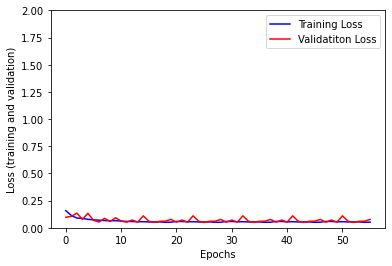

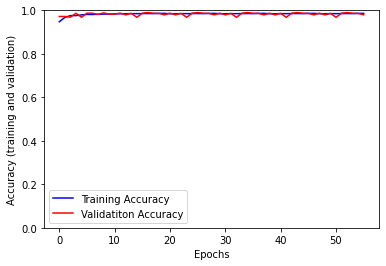

In [ ]:
accuracies.extend(hist["accuracy"])
val_accuracies.extend(hist['val_accuracy'])
losses.extend(hist['loss'])
val_losses.extend(hist['val_loss'])
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Epochs")
plt.ylim([0,2])
plt.plot(losses, 'b', label='Training Loss')
plt.plot(val_losses, 'r', label='Validatiton Loss')
plt.legend()
plt.show()

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Epochs")
plt.ylim([0,1])
plt.plot(accuracies, 'b', label='Training Accuracy')
plt.plot(val_accuracies,'r', label='Validatiton Accuracy')
plt.legend()
plt.show()

In [ ]:
#bad one
s
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

plt.legend()
plt.show()

NameError: ignored

In [ ]:
# class_distributions['Kaggle'] = {'AP':Kaggle_AP,
#                                'PA':Kaggle_PA,
#                                'Total': [f'Total Images = {Kaggle_AP+Kaggle_PA}',
#                                          f'AP Percentage = {Kaggle_AP/(Kaggle_AP+Kaggle_PA):.3f}',
#                                          f'PA Percentage = {Kaggle_PA/(Kaggle_AP+Kaggle_PA):.3f}']}

# class_distributions['IEEE'] = {'AP':IEEE_AP,
#                                'PA':IEEE_PA,
#                                'Total': [f'Total Images = {IEEE_AP+IEEE_PA}',
#                                          f'AP Percentage = {IEEE_AP/(IEEE_AP+IEEE_PA):.3f}',
#                                          f'PA Percentage = {IEEE_PA/(IEEE_AP+IEEE_PA):.3f}']}

class_distributions

In [75]:
test_dses = {
    # 'CheXpert': cheXpert_ds[2],
    # 'CX-Net': CXNet_ds[2],
    # 'ActualMed': ActualMed_ds[2],
    'Shenzhen': Shenzhen_ds[2],
    'Montgomery': Montgomery_ds[2],
    'RICORD': RICORD_ds[2],
    'Kaggle': Kaggle_Test_ds[2]
}

predictions = {}

In [76]:
#adapted from https://ecode.dev/cnn-for-medical-imaging-using-tensorflow-2/

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
for test_ds_name in test_dses:
  print('-'*40)
  print('Now evaluating '+ test_ds_name)
  test_ds = test_dses[test_ds_name]
  score_test = model.evaluate(test_ds)
  predictions[test_ds_name] = model.predict(test_ds)
  for name, value in zip(model.metrics_names, score_test):
    print(name, ': ', value)
  print('-'*40)

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# notice the threshold
def plot_cm(labels: numpy.ndarray, predictions: numpy.ndarray, p: float=0.5) -> ():
    cm = confusion_matrix(labels, predictions > p)
    # you can normalize the confusion matrix

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Lesions Detected (True Negatives): ', cm[0][0])
    print('Lesions Incorrectly Detected (False Positives): ', cm[0][1])
    print('No-Lesions Missed (False Negatives): ', cm[1][0])
    print('No-Lesions Detected (True Positives): ', cm[1][1])
    print('Total Lesions: ', np.sum(cm[1]))

def plot_roc(name: str, labels: numpy.ndarray, predictions: numpy.ndarray, **kwargs) -> ():
  fp, tp, _ = roc_curve(labels, predictions)
  auc_roc = roc_auc_score(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name + " (" + str(round(auc_roc, 3)) + ")", 
           linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('ROC curve')
  plt.grid(True)
  plt.legend(loc='best')
  ax = plt.gca()
  ax.set_aspect('equal')

for name, test_ds, y_test_pred in zip(test_dses.keys, test_dses.values, predictions.values):
  print('-'*40)
  print('NOW SHOWING PLOTS FOR: ' + name)
  y_test = np.concatenate([y for x, y in test_ds], axis=0)
  plot_cm(y_test, y_test_pred)
  plot_roc("Test Base", y_test, y_test_pred, color=colors[0])
  plt.legend(loc='lower right')
  print('-'*40)

Evaluate on test data
----------------------------------------
Now evaluating Shenzhen
27/42 [==================>...........] - ETA: 1:00 - loss: 0.3057 - tp: 387.0000 - fp: 0.0000e+00 - tn: 0.0000e+00 - fn: 45.0000 - accuracy: 0.8958 - precision: 1.0000 - recall: 0.8958 - auc: 0.0000e+00 - sensitivity: 0.0000e+00

InvalidArgumentError: ignored

In [ ]:
class_distributions